In [14]:
%matplotlib inline

In [9]:
import keras

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

In [5]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling)([z_mean, z_log_var])
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)
y = CustomVariationalLayer()([input_img, z_decoded])
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [16]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.1799 - val_loss: 0.1804
Epoch 2/10
60000/60000 [==============================] - 12s 201us/step - loss: 0.1794 - val_loss: 0.1800
Epoch 3/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.1790 - val_loss: 0.1794
Epoch 4/10
60000/60000 [==============================] - 12s 204us/step - loss: 0.1786 - val_loss: 0.1800
Epoch 5/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.1783 - val_loss: 0.1790
Epoch 6/10
60000/60000 [==============================] - 12s 207us/step - loss: 0.1779 - val_loss: 0.1785
Epoch 7/10
60000/60000 [==============================] - 12s 204us/step - loss: 0.1776 - val_loss: 0.1782
Epoch 8/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.1773 - val_loss: 0.1774
Epoch 9/10
60000/60000 [==============================] - 12s 205us/step - loss: 0.1771 - val_

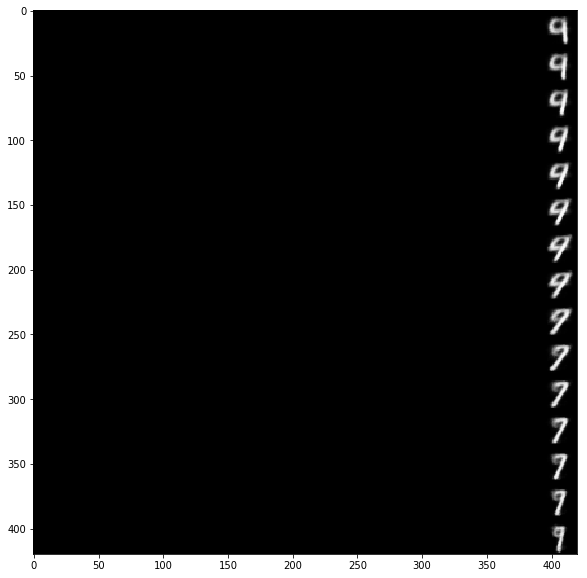

In [15]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
    j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [1]:
'''Example of VAE on MNIST dataset using CNN
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 4s 74us/step - loss: 52.2927 - val_loss: 46.9331
Epoch 2/30
60000/60000 [==============================] - 3s 50us/step - loss: 44.6456 - val_loss: 43.5202
Epoch 3/30
60000/60000 [==============================] - 3s 51us/step - loss: 42.8100 - val_loss: 41.8186
Epoch 4/30
60000/60000 [=====

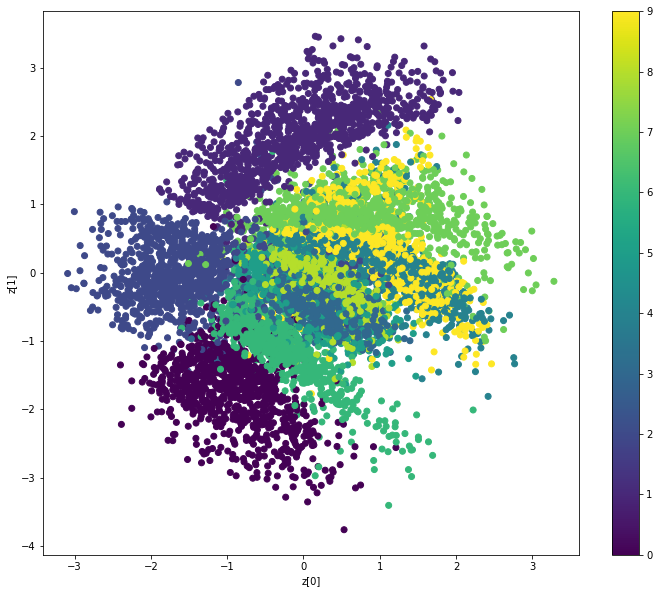

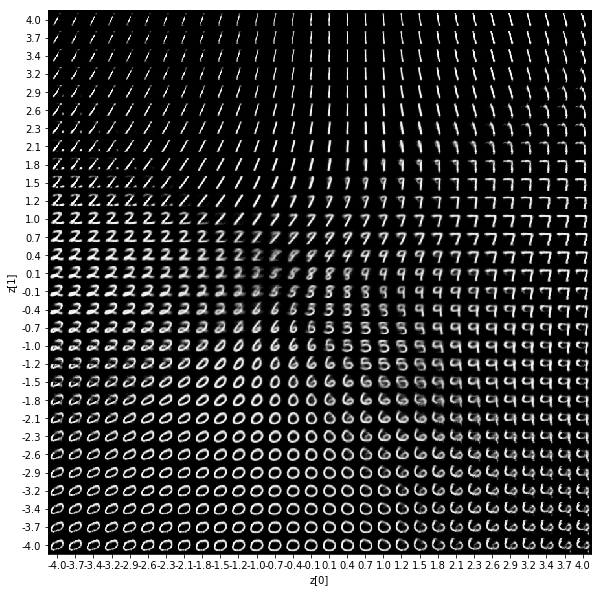

In [3]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")